In [1]:
%matplotlib inline

from itertools import groupby
import numpy as np
import pandas as pd
import scipy
import scipy.signal

#to visualize 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")


#to load files
import os
import h5py

from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical

from EMG_gestures.utils import *
from EMG_gestures.models import DANN
from EMG_gestures.analysis import DANN_test

[]

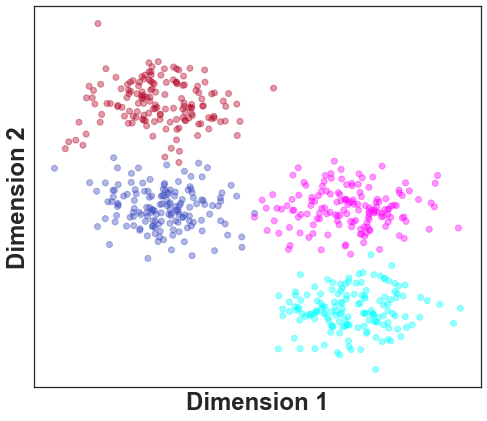

In [3]:
#make fake data and visualiz
X1, y1 = make_blobs(300, centers=[[0, 0], [0, 1]], cluster_std=0.2)
X2, y2 = make_blobs(300, centers=[[1, -1], [1, 0]], cluster_std=0.2)

fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(X1[:,0], X1[:,1], c=y1, cmap='coolwarm', alpha=0.4)
ax.scatter(X2[:,0], X2[:,1], c=y2, cmap='cool', alpha=0.4)
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())

In [4]:
epochs = 20
batch_size = 10
score_list = ['accuracy']

X_source, Y_source, scaler = prepare_data_for_log_reg(X1,y1, np.arange(X1.shape[0]), [], train = True)
X_target, Y_target, scaler = prepare_data_for_log_reg(X2,y2, np.arange(X2.shape[0]), [], scaler = scaler)

#stack
X_all = np.vstack((X_source,X_target))
Y_all = np.vstack((Y_source,Y_target))

# create domain labels
Y_all_domain = np.hstack((np.ones(X1.shape[0],)*0,np.ones(X2.shape[0],)*1))#source_label
Y_all_domain = to_categorical(Y_all_domain)



In [19]:
n_features, n_outputs = X_source.shape[1], Y_source.shape[1]

#define and compile model
input_shape = (n_features,)
dann_model = DANN(input_shape, n_outputs, fe_layers = 1, dp_layers = 1, activation = 'tanh')
dann_model.compile(loss='categorical_crossentropy')

In [20]:
np.random.seed(10)
dann_model.train_label_pred(X_source, Y_source, epochs=epochs, batch_size=batch_size, verbose=0)

In [21]:
#label class accuracy
source_label_score = get_scores(X_source, Y_source, dann_model.predict_label, score_list)
target_label_score = get_scores(X_target, Y_target, dann_model.predict_label, score_list)

#domain class accuracy
domain_score = get_scores(X_all, Y_all, dann_model.predict_domain, score_list)

print('After training on source labels ONLY:\n')
print('Source label accuracy: %.02f'%(source_label_score))
print('Target label accuracy: %.02f'%(target_label_score))
print('Domain accuracy: %.02f'%(domain_score))

After training on source labels ONLY:

Source label accuracy: 0.96
Target label accuracy: 0.50
Domain accuracy: 0.28


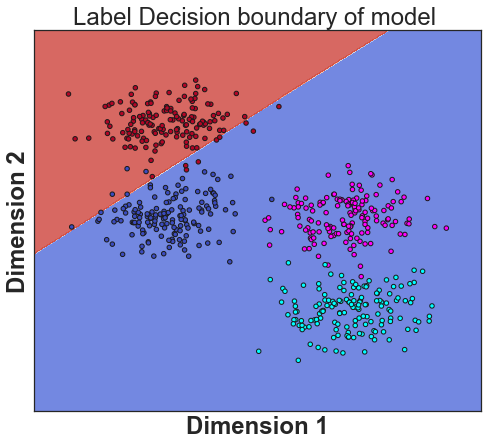

In [22]:
#Visualizing decision boundary for labels
xx, yy = make_meshgrid(X_all[:,0], X_all[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Class Label Decision Boundary ')
plot_contours(ax, dann_model.predict_label, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_source[:,0], X_source[:,1], c=np.argmax(Y_source,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_target[:,0], X_target[:,1], c=np.argmax(Y_target,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [10]:
# Domain adaptation with domain labels
np.random.seed(1)
dann_model.train_domain_adapt(X_source, Y_source, X_target,\
                              epochs = epochs*3, batch_size = batch_size, verbose = 0)

In [11]:
#label class accuracy
source_label_score = get_scores(X_source, Y_source, dann_model.predict_label, score_list)
target_label_score = get_scores(X_target, Y_target, dann_model.predict_label, score_list)

#domain class accuracy
domain_score = get_scores(X_all, Y_all, dann_model.predict_domain, score_list)

print('After domain adapttion:\n')
print('Source label accuracy: %.02f'%(source_label_score))
print('Target label accuracy: %.02f'%(target_label_score))
print('Domain accuracy: %.02f'%(domain_score))


After domain adapttion:

Source label accuracy: 0.98
Target label accuracy: 0.50
Domain accuracy: 0.23


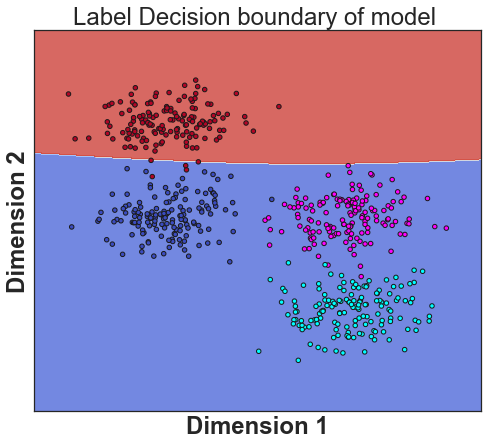

In [12]:
#Visualizing decision boundary for labels
xx, yy = make_meshgrid(X_all[:,0], X_all[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Class Label Decision Boundary ')
plot_contours(ax, dann_model.predict_label, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_source[:,0], X_source[:,1], c=np.argmax(Y_source,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_target[:,0], X_target[:,1], c=np.argmax(Y_target,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [24]:
# with labels revealed

#define and compile model
input_shape = (n_features,)
dann_model = DANN(input_shape, n_outputs, fe_layers = 1, dp_layers = 1, activation = 'tanh')
dann_model.compile(loss='categorical_crossentropy')

In [25]:
np.random.seed(1)
dann_model.train_domain_and_labels(X_source, Y_source, X_target, Y_target,\
                                   epochs=epochs*2, batch_size=batch_size, verbose=0)

In [26]:
#label class accuracy
source_label_score = get_scores(X_source, Y_source, dann_model.predict_label, score_list)
target_label_score = get_scores(X_target, Y_target, dann_model.predict_label, score_list)

#domain class accuracy
domain_score = get_scores(X_all, Y_all, dann_model.predict_domain, score_list)

print('After training with ALL labels revealed:\n')
print('Source label accuracy: %.02f'%(source_label_score))
print('Target label accuracy: %.02f'%(target_label_score))
print('Domain accuracy: %.02f'%(domain_score))

After training with ALL labels revealed:

Source label accuracy: 0.95
Target label accuracy: 0.95
Domain accuracy: 0.26


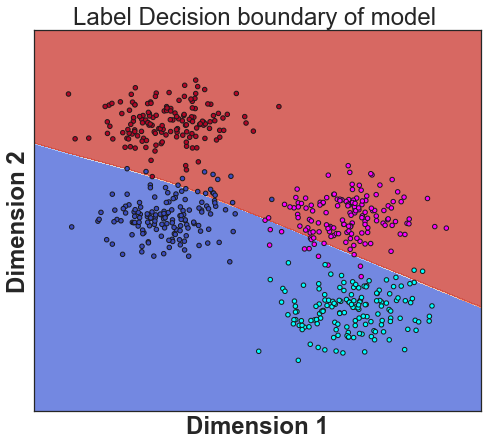

In [27]:
#Visualizing decision boundary for labels
xx, yy = make_meshgrid(X_all[:,0], X_all[:,1])

fig, ax = plt.subplots(figsize=(8,7))
title = ('Class Label Decision Boundary ')
plot_contours(ax, dann_model.predict_label, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X_source[:,0], X_source[:,1], c=np.argmax(Y_source,1), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.scatter(X_target[:,0], X_target[:,1], c=np.argmax(Y_target,1), cmap=plt.cm.cool, s=20, edgecolors='k')
ax.set_ylabel('Dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

In [ ]:
#repeat

epochs = 20
batch_size = 10
score_list = ['accuracy']
n_splits = 3
nreps = 10


np.random.seed(1)
results_df = []
for rep in range(nreps):
    print('Rep %d'%(rep+1))
    print('---- True Data---')
    
    sub_df = DANN_test(X1, y1, X2, y2, score_list, n_splits,\
                           epochs, batch_size)
    sub_df['Rep'] = rep+1
    sub_df['Shuffled'] = False
    
    print('---- Permuted Data---')
    results_df.append(sub_df)
    sub_df = DANN_test(X1, y1, X2, y2, score_list, n_splits,\
                           epochs, batch_size, permute = True)
    sub_df['Rep'] = rep+1
    sub_df['Shuffled'] = True
    results_df.append(sub_df)
    
results_df = pd.concat(results_df, axis = 0)

#save to file

Rep 1
Split Count: 1
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 2
Training on Source Labels
Adapting to target Domain
Training with all labels revealed
Split Count: 3
Training on Source Labels
Adapting to target Domain


In [ ]:
results_fn = './DANN_test_multiple_runs_results.h5'%(subject_id,n_shuffled_sets)
results_df.to_hdf(results_fn, key='results_df', mode='w')

In [ ]:
#visualize results

#average over folds
keep_types = ['Source_Test','Naive_Target_Test','Adapt_Source_Test']
plot_df = results_df.loc[results_df.Type.isin(keep_types)]
plot_df = plot_df.groupby(['Type','Shuffled','Rep'])\
.mean()\
.drop(columns = ['Fold'])\
.reset_index()

shuffle_df = plot_df.loc[plot_df.Shuffled == True]
true_df = plot_df.loc[plot_df.Shuffled == False]

# Get confidence interval for shuffled data results
null_ci = np.zeros((len(keep_types),2))

for j,t in enumerate(keep_types):
    null_df = shuffle_df.loc[shuffle_df.Type == t]
    null_ci[j,:] = sns.utils.ci(sns.algorithms.bootstrap(null_df['accuracy_score'].values))


#make plot
g = sns.catplot(data = true_df, x= 'Type', y = 'accuracy_score', hue = 'Type',\
            order = keep_types, kind = 'box', aspect = 3)

# #Label axes and subpots, mark chance confidence interval
for i,ax in enumerate(g.axes[0]):
    ax.set_xlabel('')
    ax.set_xticklabels(keep_types,horizontalalignment = 'center')
    ax.set_ylabel('Accuracy')
    for j,t in enumerate(keep_types):
        ax.add_patch(patches.Rectangle((.75*j, null_ci[j,0]), 0.5, (null_ci[j,1]-null_ci[j,0]),\
                                             linewidth=0, fill=True, color='k', alpha=0.2))

sns.despine(fig=g.fig, bottom = True)